In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_train.parquet
/kaggle/input/the-future-crop-challenge/sample_submission.csv
/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_train.parquet
/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_test.parquet
/kaggle/input/the-future-crop-challenge/soil_co2_maize_test.parquet
/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_test.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_test.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_test.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_train.parquet
/kaggle/input/the-fu

In [4]:
def summarize_time_series(df, id_cols, prefix):
    # If ID is in index, reset it to bring as column(s)
    if not all(col in df.columns for col in id_cols):
        df = df.reset_index()

    # Select numeric columns excluding id_cols
    ts_cols = df.drop(columns=id_cols, errors='ignore').select_dtypes(include='number').columns.tolist()

    # Copy ID columns for summary_df
    summary_df = df[id_cols].copy()

    # Compute summary statistics row-wise for ts_cols
    summary_df[f'{prefix}_mean'] = df[ts_cols].mean(axis=1)
    summary_df[f'{prefix}_std'] = df[ts_cols].std(axis=1)
    summary_df[f'{prefix}_min'] = df[ts_cols].min(axis=1)
    summary_df[f'{prefix}_max'] = df[ts_cols].max(axis=1)
    summary_df[f'{prefix}_median'] = df[ts_cols].median(axis=1)
    summary_df[f'{prefix}_trend'] = df[ts_cols].apply(lambda row: row.diff().mean(), axis=1)

    return summary_df


In [5]:
# Define your ID columns
id_cols = ['ID','crop','year', 'lat', 'lon']

# File mapping (update file paths accordingly)
files = {
    'precip': '/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet',
    'srad': '/kaggle/input/the-future-crop-challenge/rsds_wheat_train.parquet',
    'tmean': '/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet',
    'tmax': '/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet',
    'tmin': '/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet'
}


In [6]:
summarized_dfs = []

for prefix, file in files.items():
    print(f"Processing: {file}")
    df = pd.read_parquet(file)

    # Reset index if needed (your function also does this)
    if df.index.name == 'ID' and 'ID' not in df.columns:
        df = df.reset_index()

    summary = summarize_time_series(df, id_cols=id_cols, prefix=prefix)
    summarized_dfs.append(summary)

Processing: /kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
Processing: /kaggle/input/the-future-crop-challenge/rsds_wheat_train.parquet
Processing: /kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
Processing: /kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
Processing: /kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet


In [7]:
from functools import reduce
final_summary = reduce(lambda left, right: pd.merge(left, right, on=id_cols, how='outer'), summarized_dfs)
final_summary.head()

,ID,crop,year,lat,lon,precip_mean,precip_std,precip_min,precip_max,precip_median,...,tmax_min,tmax_max,tmax_median,tmax_trend,tmin_mean,tmin_std,tmin_min,tmin_max,tmin_median,tmin_trend
0,1040990,wheat,381.0,44.75,-123.25,0.000087,0.000125,0.0,0.000642,0.000034,...,-1.137970,32.060333,12.743103,-0.031067,4.379208,3.859072,-9.583160,13.177643,4.785172,-0.019412
1,1040991,wheat,381.0,45.25,-123.25,0.000091,0.000128,0.0,0.000710,0.000042,...,-2.419830,31.235260,12.359253,-0.036667,4.064107,3.804593,-10.941071,13.372467,4.501678,-0.013600
2,1040992,wheat,381.0,45.75,-123.25,0.000104,0.000144,0.0,0.000747,0.000052,...,-3.342865,30.058044,10.910874,-0.040008,3.127993,3.851878,-12.929657,12.391998,3.423889,-0.015057
3,1040993,wheat,381.0,44.75,-122.75,0.000095,0.000138,0.0,0.000717,0.000037,...,-1.801300,32.426056,12.241913,-0.022108,3.691531,4.087084,-11.055267,13.634766,4.007050,-0.023321
4,1040994,wheat,381.0,45.25,-122.75,0.000075,0.000114,0.0,0.000662,0.000032,...,-2.606445,33.562530,13.037262,-0.035670,4.361445,4.034662,-11.129517,14.687836,4.814819,-0.016279


In [8]:
# Assuming final_summary is the combined summary DataFrame from before
soil = pd.read_parquet("/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet")

# If soil DataFrame has ID as index, reset index
if soil.index.name == 'ID' and 'ID' not in soil.columns:
    soil = soil.reset_index()

# Check if all id_cols are in soil
missing_cols = [col for col in id_cols if col not in soil.columns]
if missing_cols:
    print(f"Warning: Missing columns in soil dataset: {missing_cols}")

# Merge soil data with final summary on id_cols
final_df = pd.merge(final_summary, soil, on=id_cols, how='inner')

final_df.head()


,ID,crop,year,lat,lon,precip_mean,precip_std,precip_min,precip_max,precip_median,...,tmin_mean,tmin_std,tmin_min,tmin_max,tmin_median,tmin_trend,texture_class,real_year,co2,nitrogen
0,1040990,wheat,381.0,44.75,-123.25,0.000087,0.000125,0.0,0.000642,0.000034,...,4.379208,3.859072,-9.583160,13.177643,4.785172,-0.019412,9.0,1982,340.79,102.824997
1,1040991,wheat,381.0,45.25,-123.25,0.000091,0.000128,0.0,0.000710,0.000042,...,4.064107,3.804593,-10.941071,13.372467,4.501678,-0.013600,9.0,1982,340.79,102.824997
2,1040992,wheat,381.0,45.75,-123.25,0.000104,0.000144,0.0,0.000747,0.000052,...,3.127993,3.851878,-12.929657,12.391998,3.423889,-0.015057,9.0,1982,340.79,102.824997
3,1040993,wheat,381.0,44.75,-122.75,0.000095,0.000138,0.0,0.000717,0.000037,...,3.691531,4.087084,-11.055267,13.634766,4.007050,-0.023321,9.0,1982,340.79,102.824997
4,1040994,wheat,381.0,45.25,-122.75,0.000075,0.000114,0.0,0.000662,0.000032,...,4.361445,4.034662,-11.129517,14.687836,4.814819,-0.016279,9.0,1982,340.79,102.824997


In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278747 entries, 0 to 278746
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             278747 non-null  int64  
 1   crop           278747 non-null  object 
 2   year           278747 non-null  float64
 3   lat            278747 non-null  float64
 4   lon            278747 non-null  float64
 5   precip_mean    278747 non-null  float64
 6   precip_std     278747 non-null  float64
 7   precip_min     278747 non-null  float64
 8   precip_max     278747 non-null  float64
 9   precip_median  278747 non-null  float64
 10  precip_trend   278747 non-null  float64
 11  srad_mean      278747 non-null  float64
 12  srad_std       278747 non-null  float64
 13  srad_min       278747 non-null  float64
 14  srad_max       278747 non-null  float64
 15  srad_median    278747 non-null  float64
 16  srad_trend     278747 non-null  float64
 17  tmean_mean     278747 non-nul

In [10]:
yield_df = pd.read_parquet('/kaggle/input/the-future-crop-challenge/train_solutions_wheat.parquet')


In [11]:
# If yield_df index is ID and not a column, reset it
if yield_df.index.name == 'ID' and 'ID' not in yield_df.columns:
    yield_df = yield_df.reset_index()

# Merge on common keys
m_df = pd.merge(final_df, yield_df, on=['ID'], how='inner')

m_df.head()

,ID,crop,year,lat,lon,precip_mean,precip_std,precip_min,precip_max,precip_median,...,tmin_std,tmin_min,tmin_max,tmin_median,tmin_trend,texture_class,real_year,co2,nitrogen,yield
0,1040990,wheat,381.0,44.75,-123.25,0.000087,0.000125,0.0,0.000642,0.000034,...,3.859072,-9.583160,13.177643,4.785172,-0.019412,9.0,1982,340.79,102.824997,4.775
1,1040991,wheat,381.0,45.25,-123.25,0.000091,0.000128,0.0,0.000710,0.000042,...,3.804593,-10.941071,13.372467,4.501678,-0.013600,9.0,1982,340.79,102.824997,4.874
2,1040992,wheat,381.0,45.75,-123.25,0.000104,0.000144,0.0,0.000747,0.000052,...,3.851878,-12.929657,12.391998,3.423889,-0.015057,9.0,1982,340.79,102.824997,4.701
3,1040993,wheat,381.0,44.75,-122.75,0.000095,0.000138,0.0,0.000717,0.000037,...,4.087084,-11.055267,13.634766,4.007050,-0.023321,9.0,1982,340.79,102.824997,4.848
4,1040994,wheat,381.0,45.25,-122.75,0.000075,0.000114,0.0,0.000662,0.000032,...,4.034662,-11.129517,14.687836,4.814819,-0.016279,9.0,1982,340.79,102.824997,5.178


In [12]:
m_df.isnull().sum()

ID               0
crop             0
year             0
lat              0
lon              0
precip_mean      0
precip_std       0
precip_min       0
precip_max       0
precip_median    0
precip_trend     0
srad_mean        0
srad_std         0
srad_min         0
srad_max         0
srad_median      0
srad_trend       0
tmean_mean       0
tmean_std        0
tmean_min        0
tmean_max        0
tmean_median     0
tmean_trend      0
tmax_mean        0
tmax_std         0
tmax_min         0
tmax_max         0
tmax_median      0
tmax_trend       0
tmin_mean        0
tmin_std         0
tmin_min         0
tmin_max         0
tmin_median      0
tmin_trend       0
texture_class    0
real_year        0
co2              0
nitrogen         0
yield            0
dtype: int64

In [13]:
m_df = m_df.drop(columns='crop')

In [26]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278747 entries, 0 to 278746
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             278747 non-null  int64  
 1   year           278747 non-null  float64
 2   lat            278747 non-null  float64
 3   lon            278747 non-null  float64
 4   precip_mean    278747 non-null  float64
 5   precip_std     278747 non-null  float64
 6   precip_min     278747 non-null  float64
 7   precip_max     278747 non-null  float64
 8   precip_median  278747 non-null  float64
 9   precip_trend   278747 non-null  float64
 10  srad_mean      278747 non-null  float64
 11  srad_std       278747 non-null  float64
 12  srad_min       278747 non-null  float64
 13  srad_max       278747 non-null  float64
 14  srad_median    278747 non-null  float64
 15  srad_trend     278747 non-null  float64
 16  tmean_mean     278747 non-null  float64
 17  tmean_std      278747 non-nul

In [27]:
float64_cols = m_df.select_dtypes(include='float64').columns
print("Float64 Columns:", float64_cols.tolist())

Float64 Columns: ['year', 'lat', 'lon', 'precip_mean', 'precip_std', 'precip_min', 'precip_max', 'precip_median', 'precip_trend', 'srad_mean', 'srad_std', 'srad_min', 'srad_max', 'srad_median', 'srad_trend', 'tmean_mean', 'tmean_std', 'tmean_min', 'tmean_max', 'tmean_median', 'tmean_trend', 'tmax_mean', 'tmax_std', 'tmax_min', 'tmax_max', 'tmax_median', 'tmax_trend', 'tmin_mean', 'tmin_std', 'tmin_min', 'tmin_max', 'tmin_median', 'tmin_trend', 'texture_class', 'co2', 'yield']


In [28]:
stats = m_df[float64_cols].agg(['min', 'max', 'mean', 'std']).T
stats

,min,max,mean,std
year,3.810000e+02,419.000000,3.999246e+02,1.130137e+01
lat,-4.125000e+01,64.750000,3.578165e+01,2.564101e+01
lon,-1.232500e+02,152.750000,1.895301e+01,7.102990e+01
precip_mean,8.626615e-08,0.000289,2.178784e-05,1.245067e-05
precip_std,8.314265e-07,0.000455,5.166238e-05,2.840872e-05
precip_min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
precip_max,1.116770e-05,0.004164,3.898004e-04,2.365094e-04
precip_median,0.000000e+00,0.000059,1.254033e-06,2.848579e-06
precip_trend,-1.122378e-05,0.000008,-2.221431e-08,3.935808e-07
srad_mean,4.170005e+01,286.110309,1.280438e+02,4.290493e+01


In [29]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278747 entries, 0 to 278746
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             278747 non-null  int64  
 1   year           278747 non-null  float64
 2   lat            278747 non-null  float64
 3   lon            278747 non-null  float64
 4   precip_mean    278747 non-null  float64
 5   precip_std     278747 non-null  float64
 6   precip_min     278747 non-null  float64
 7   precip_max     278747 non-null  float64
 8   precip_median  278747 non-null  float64
 9   precip_trend   278747 non-null  float64
 10  srad_mean      278747 non-null  float64
 11  srad_std       278747 non-null  float64
 12  srad_min       278747 non-null  float64
 13  srad_max       278747 non-null  float64
 14  srad_median    278747 non-null  float64
 15  srad_trend     278747 non-null  float64
 16  tmean_mean     278747 non-null  float64
 17  tmean_std      278747 non-nul

In [32]:
float_cols = m_df.select_dtypes(include=['float64']).columns
m_df[float_cols] = m_df[float_cols].astype(np.float32)

In [33]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278747 entries, 0 to 278746
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             278747 non-null  int64  
 1   year           278747 non-null  float32
 2   lat            278747 non-null  float32
 3   lon            278747 non-null  float32
 4   precip_mean    278747 non-null  float32
 5   precip_std     278747 non-null  float32
 6   precip_min     278747 non-null  float32
 7   precip_max     278747 non-null  float32
 8   precip_median  278747 non-null  float32
 9   precip_trend   278747 non-null  float32
 10  srad_mean      278747 non-null  float32
 11  srad_std       278747 non-null  float32
 12  srad_min       278747 non-null  float32
 13  srad_max       278747 non-null  float32
 14  srad_median    278747 non-null  float32
 15  srad_trend     278747 non-null  float32
 16  tmean_mean     278747 non-null  float32
 17  tmean_std      278747 non-nul

In [36]:
m_df.head()

,ID,year,lat,lon,precip_mean,precip_std,precip_min,precip_max,precip_median,precip_trend,...,tmin_std,tmin_min,tmin_max,tmin_median,tmin_trend,texture_class,real_year,co2,nitrogen,yield
0,1040990,381.0,44.75,-123.25,0.000087,0.000125,0.0,0.000642,0.000034,-4.744572e-08,...,3.859071,-9.583160,13.177643,4.785172,-0.019412,9.0,1982,340.790009,102.824997,4.775
1,1040991,381.0,45.25,-123.25,0.000091,0.000128,0.0,0.000710,0.000042,-7.500419e-09,...,3.804593,-10.941071,13.372467,4.501678,-0.013600,9.0,1982,340.790009,102.824997,4.874
2,1040992,381.0,45.75,-123.25,0.000104,0.000144,0.0,0.000747,0.000052,4.343618e-09,...,3.851878,-12.929657,12.391998,3.423889,-0.015057,9.0,1982,340.790009,102.824997,4.701
3,1040993,381.0,44.75,-122.75,0.000095,0.000138,0.0,0.000717,0.000037,-1.312478e-07,...,4.087084,-11.055267,13.634766,4.007050,-0.023321,9.0,1982,340.790009,102.824997,4.848
4,1040994,381.0,45.25,-122.75,0.000075,0.000114,0.0,0.000662,0.000032,-1.756535e-08,...,4.034662,-11.129517,14.687836,4.814819,-0.016279,9.0,1982,340.790009,102.824997,5.178


## 1. Distribution of Yield

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


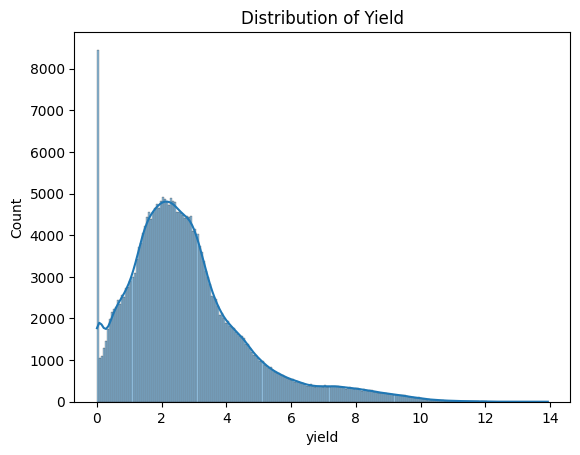

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(m_df['yield'], kde=True)
plt.title("Distribution of Yield")
plt.show()

## 2. Correlation with Yield

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


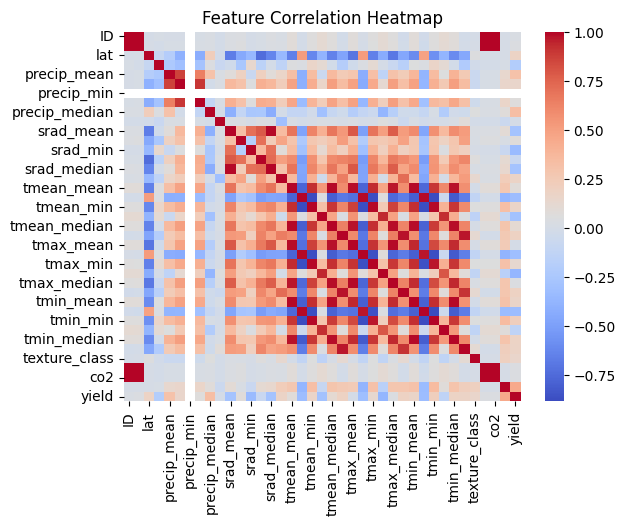

In [38]:
sns.heatmap(m_df.corr(numeric_only=True), fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## 3. Geospatial Analysis (Yield by Location)

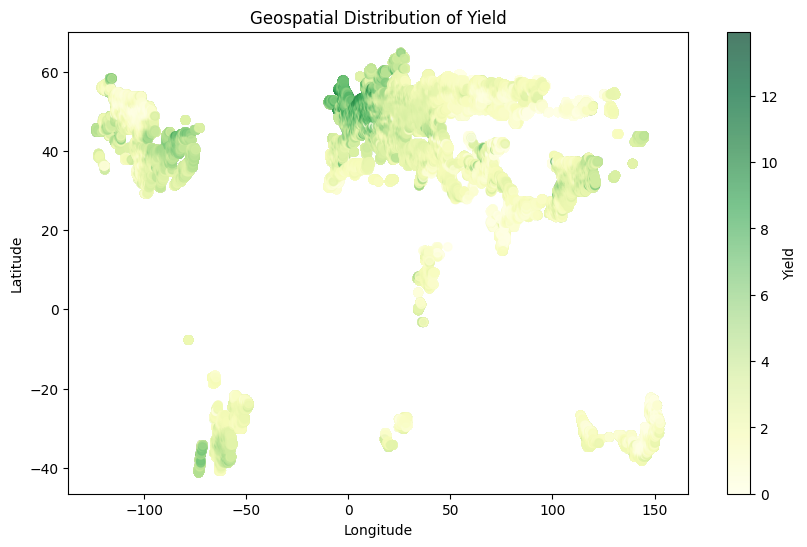

In [39]:
plt.figure(figsize=(10,6))
sc = plt.scatter(m_df['lon'], m_df['lat'], c=m_df['yield'], cmap='YlGn', alpha=0.7)
plt.colorbar(sc, label='Yield')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geospatial Distribution of Yield")
plt.show()


## 4. Temporal Trends (Year-wise Yield)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


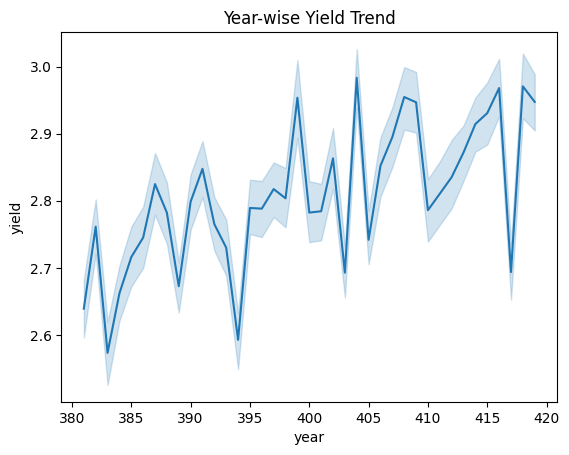

In [40]:
sns.lineplot(data=m_df, x='year', y='yield')
plt.title("Year-wise Yield Trend")
plt.show()


## 5. Yield vs CO₂ / Nitrogen

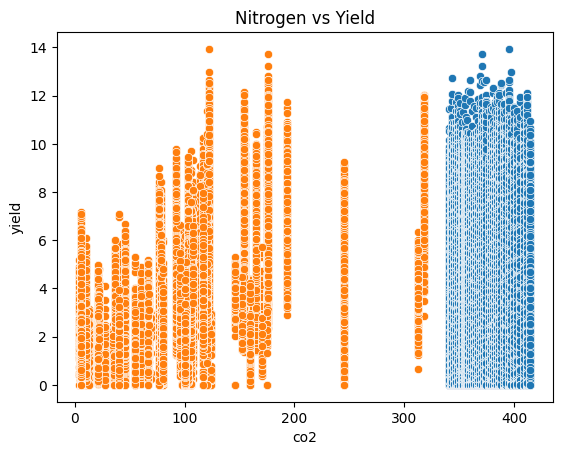

In [41]:
sns.scatterplot(data=m_df, x='co2', y='yield')
plt.title("CO2 vs Yield")

sns.scatterplot(data=m_df, x='nitrogen', y='yield')
plt.title("Nitrogen vs Yield")
plt.show()

## 6. Texture Class Impact on Yield

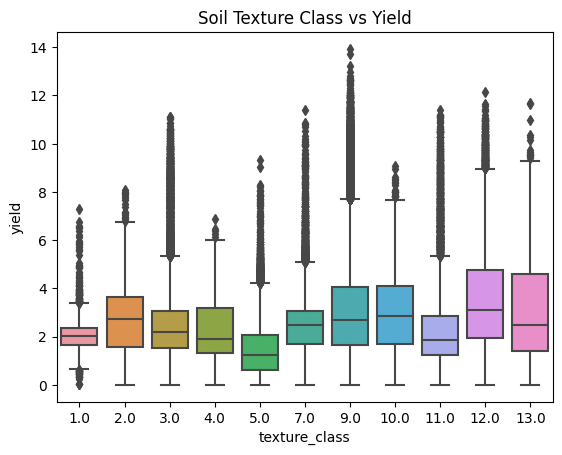

In [42]:
sns.boxplot(data=m_df, x='texture_class', y='yield')
plt.title("Soil Texture Class vs Yield")
plt.show()

## 7. Compare Top Features from Summary Stats

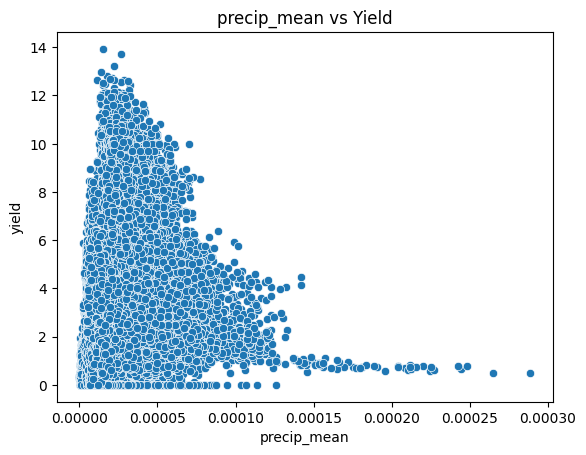

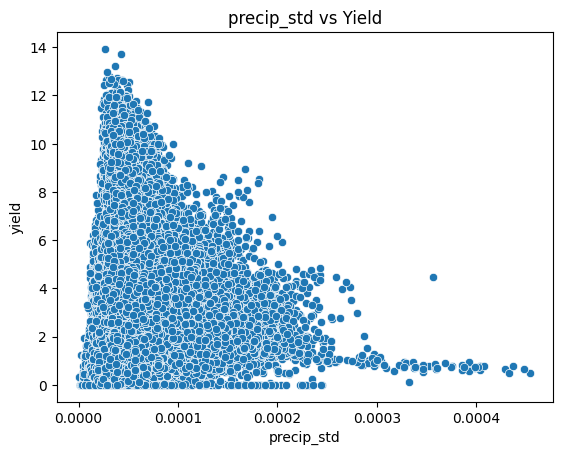

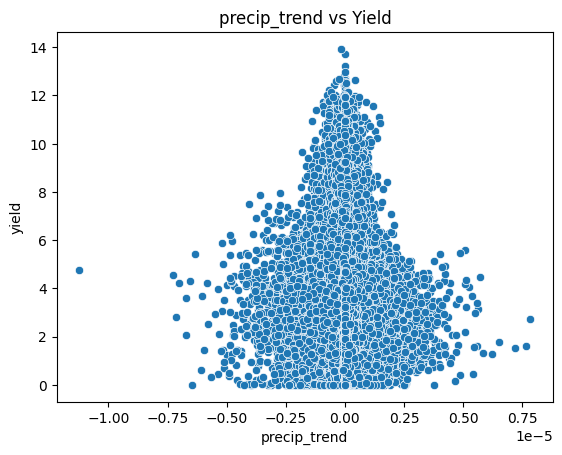

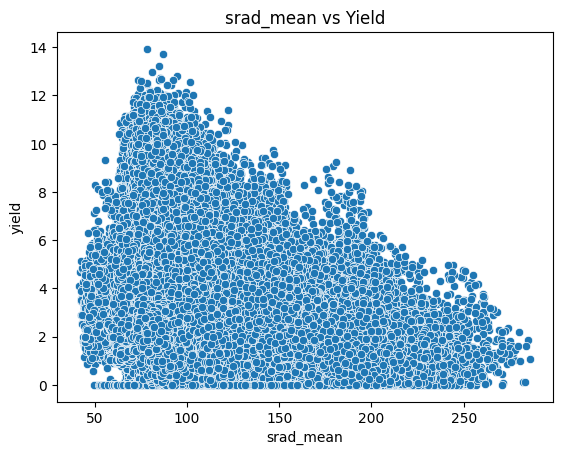

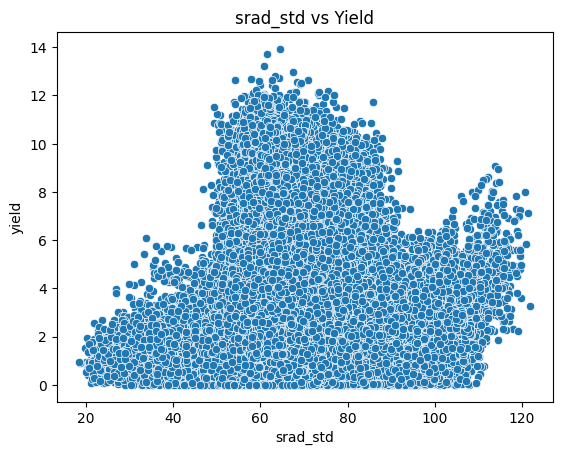

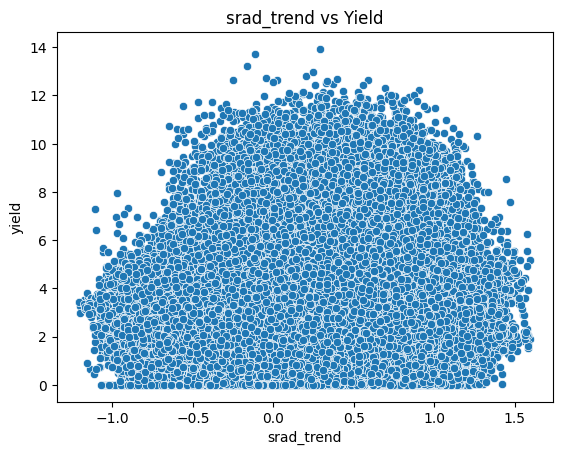

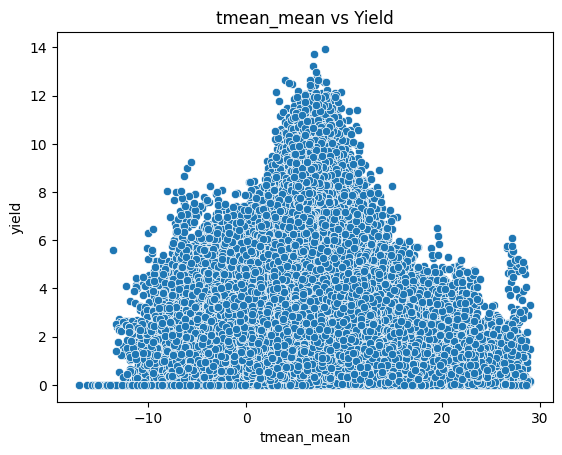

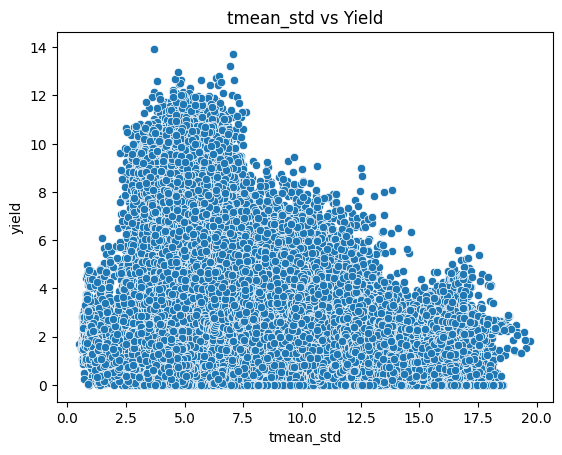

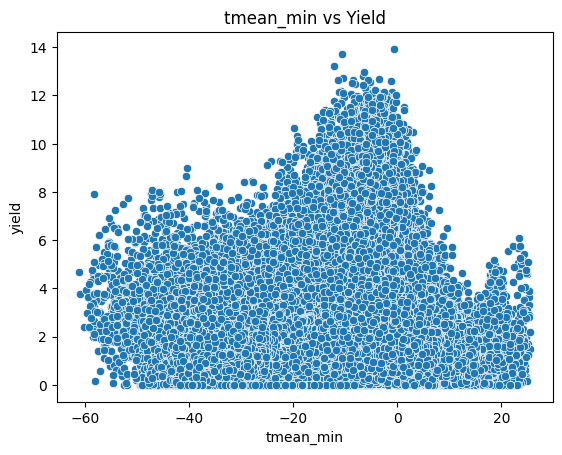

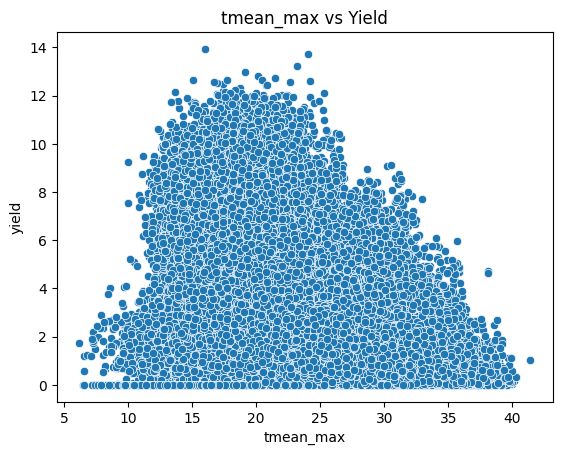

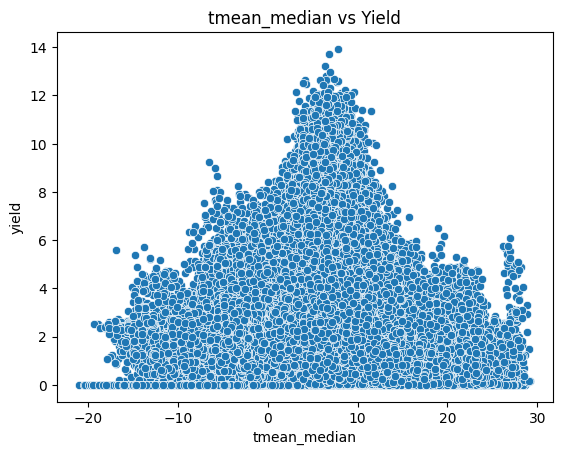

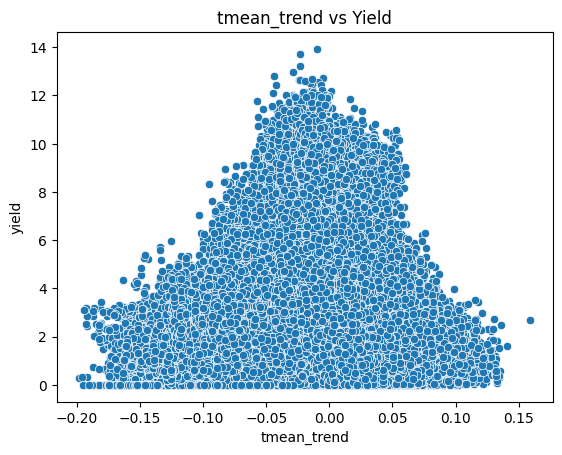

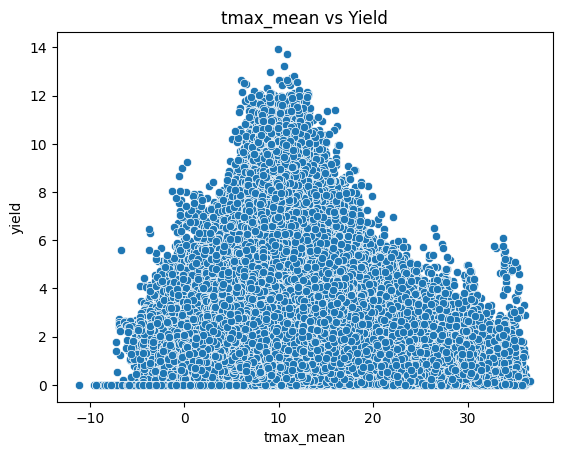

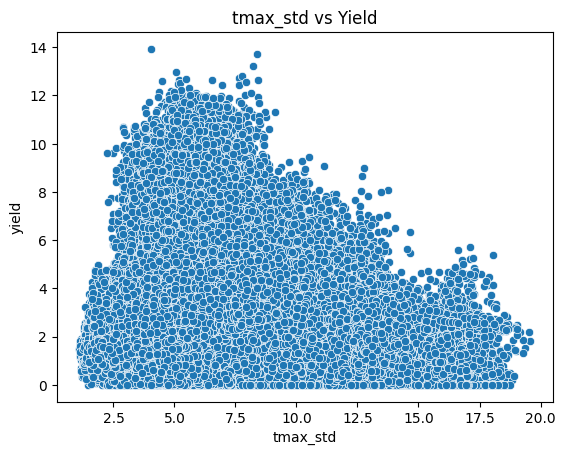

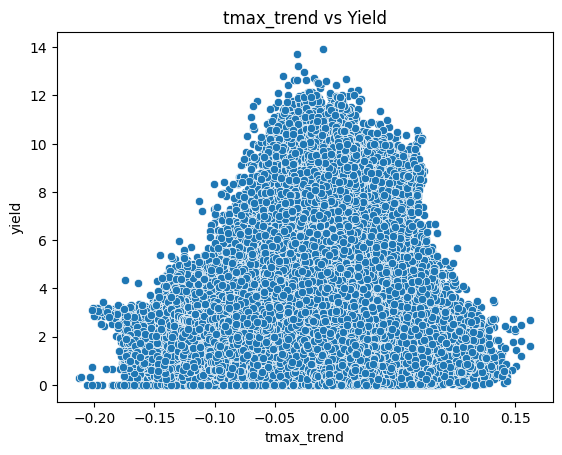

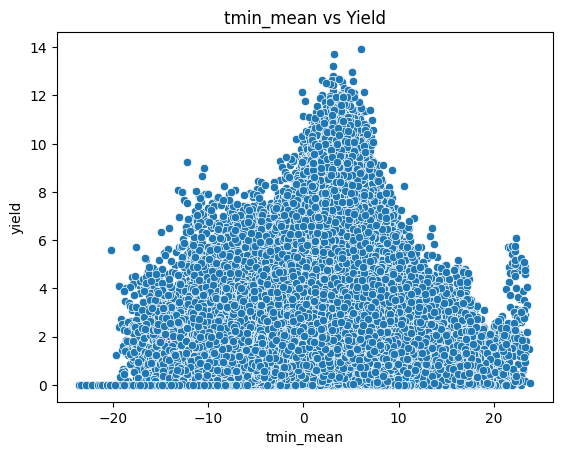

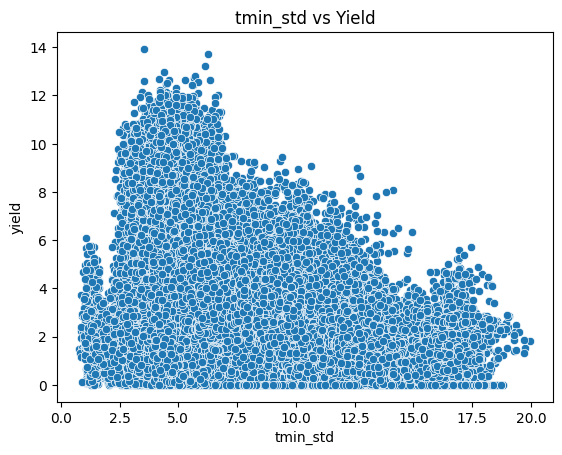

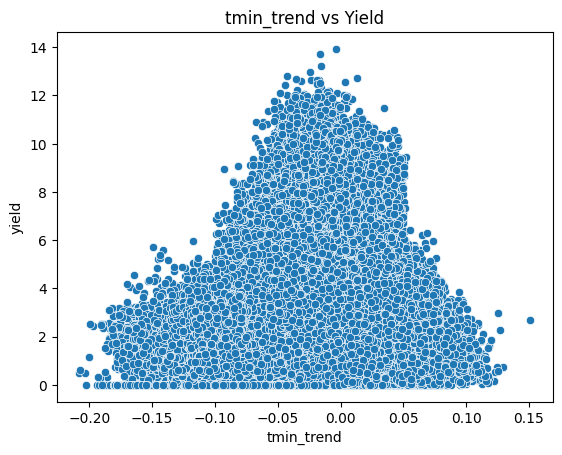

In [43]:
summary_cols = [col for col in m_df.columns if any(stat in col for stat in ['mean', 'std', 'trend'])]
for col in summary_cols:
    sns.scatterplot(data=m_df, x=col, y='yield')
    plt.title(f"{col} vs Yield")
    plt.show()

# ML

In [44]:
from sklearn.model_selection import train_test_split

# Drop non-feature columns
drop_cols = ['id', 'lat', 'lon','yield']  # 'yield' is target
feature_cols = [col for col in m_df.columns if col not in drop_cols]

# Define X (features) and y (target)
X = m_df[feature_cols]
y = m_df['yield']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (222997, 36)
Test shape: (55750, 36)


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Optimized param distribution (balanced, not too heavy)
param_dist = {
    'n_estimators': [100, 150, 200],                   # fewer trees for speed
    'max_depth': [10, 20, None],                       # fewer levels
    'min_samples_split': [2, 5],                       # common splits
    'min_samples_leaf': [1, 2],                        # small leaf sizes
    'max_features': ['sqrt', 'log2']                   # standard feature subsets
}


In [46]:

# Initialize RF
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# RandomizedSearchCV with fewer combinations
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,                        # reduce to 10 iterations to limit training
    cv=3,                             # 3-fold cross-validation
    scoring='neg_root_mean_squared_error',
    verbose=2,
    refit=True                        # still fit best model for later use
)

# Fit the model
search.fit(X_train, y_train)

# Best parameters
print("Best RF params:", search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  38.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  37.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  37.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  46.4s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  47.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  47.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.2min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200

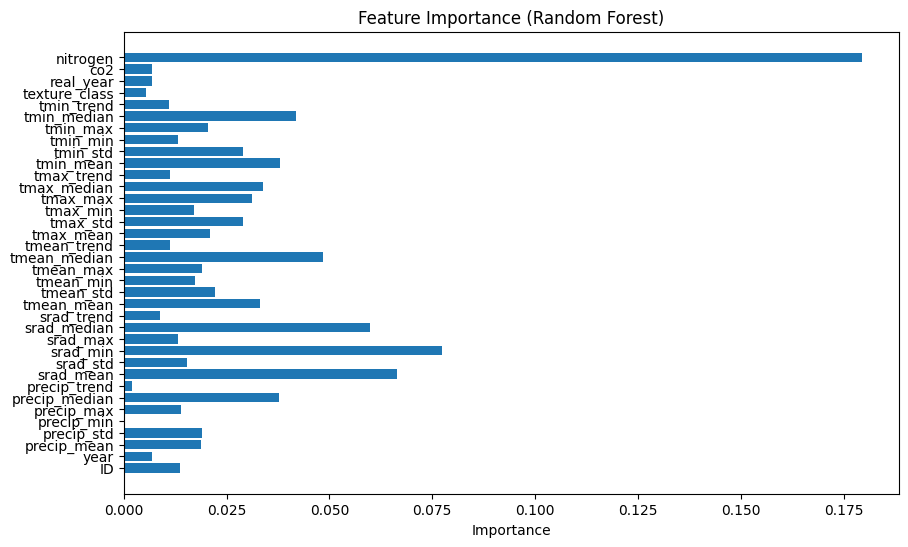

In [47]:
importances = search.best_estimator_.feature_importances_
feat_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feat_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [48]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Define the model
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # faster and uses less memory
)

# Optimized param grid (less memory-intensive)
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

In [51]:
# RandomizedSearchCV setup
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,  # fewer iterations for speed/memory
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    refit=True
)

# Fit the model
xgb_search.fit(X_train, y_train)

# Show best params
print("Best XGB params:", xgb_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.1, reg_lambda=1.5, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.1, reg_lambda=1.5, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=150, reg_alpha=0.1, reg_lambda=1.5, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=150, reg_alpha=0.1, reg_lambda=1, subsample=0.7; total time=   2.8s
[CV

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_rf_model = search.best_estimator_
best_xgb_model = xgb_search.best_estimator_

# Predict with tuned models
rf_preds = best_rf_model.predict(X_test)
xgb_preds = best_xgb_model.predict(X_test)

# Evaluate
def evaluate_model(y_true, y_pred, name="Model"):
    print(f"📊 {name} Evaluation:")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")

evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")

📊 Random Forest Evaluation:
RMSE: 0.8252
MAE: 0.5988
R² Score: 0.8134
📊 XGBoost Evaluation:
RMSE: 0.8237
MAE: 0.5977
R² Score: 0.8141


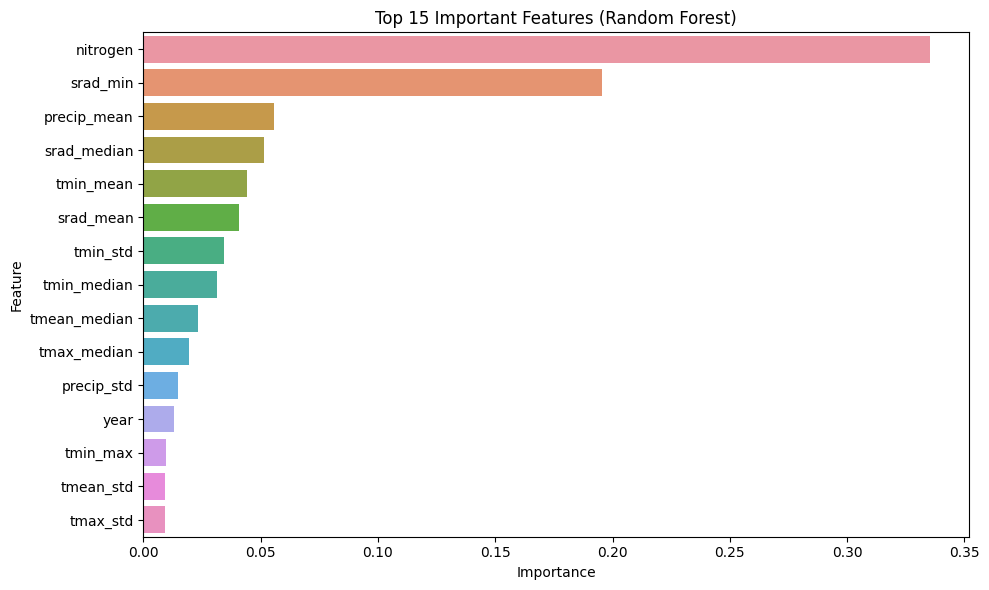

In [53]:
# Assuming your training features are in X_train
importances = best_xgb_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title("Top 15 Important Features (Random Forest)")
plt.tight_layout()
plt.show()


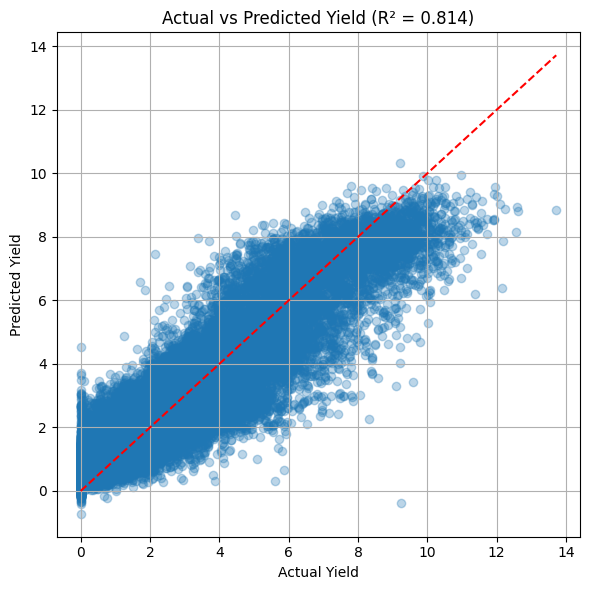

In [54]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

y_pred = best_xgb_model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title(f'Actual vs Predicted Yield (R² = {r2_score(y_test, y_pred):.3f})')
plt.grid(True)
plt.tight_layout()
plt.show()


         feature  importance
35      nitrogen    0.335120
10      srad_min    0.195524
2    precip_mean    0.055604
12   srad_median    0.051658
26     tmin_mean    0.044040
8      srad_mean    0.040633
27      tmin_std    0.034392
30   tmin_median    0.031461
18  tmean_median    0.023278
24   tmax_median    0.019392


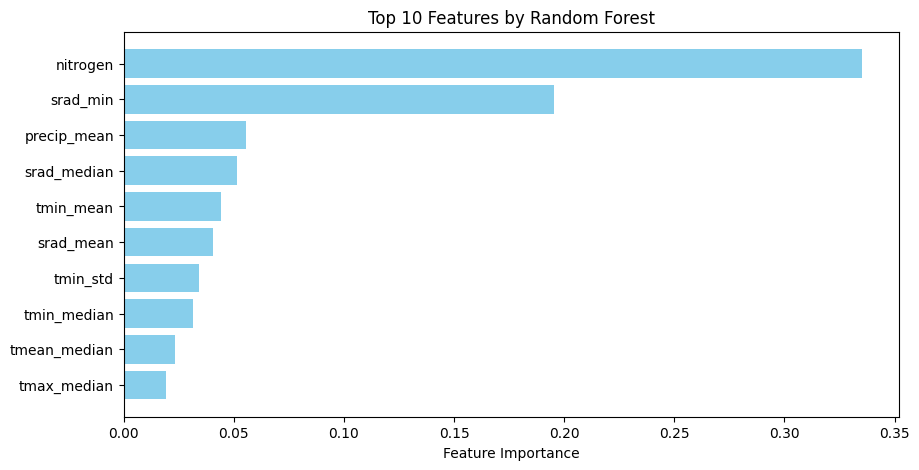

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the best model
importances = best_xgb_model.feature_importances_
feature_names = X_train.columns  # Assuming you used pandas DataFrame

# Create a DataFrame for feature importance
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top N features
top_n = 10
top_features = feat_imp_df.head(top_n)
print(top_features)

# Optional: plot
plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Features by Random Forest")
plt.gca().invert_yaxis()
plt.show()

In [57]:
import os 
os.chdir(r'/kaggle/working')

In [59]:
import joblib
joblib.dump(best_xgb_model, "best_xgb_model.joblib",compress=9)

['best_xgb_model.joblib']

In [62]:
X_train.to_csv('X_train.csv', index=False)

In [63]:
!du -sh * 

540K	best_xgb_model.joblib
74M	X_train.csv


In [64]:
from IPython.display import FileLink
FileLink(r'X_train.csv')

/kaggle/working/X_train.csv

In [65]:
FileLink(r'best_xgb_model.joblib')

/kaggle/working/best_xgb_model.joblib